# **Information extraction**
Build an information extraction system and populate a well-organized database 


### Extract below information from unstructured data:

* **Category and Subcategory of Human Trafficking**:
    * Sex Trafficking
        * Adult Sex Trafficking
        * Child Sex Trafficking
    * Labor
        * Bonded Labor or Debt Bondage
        * Domestic Servitude
        * Forced Child Labor
        * Unlawful Recruitment and Use of Child Soldiers
    * Organ Removal
    * Not Human Trafficking Article
    * Something else
* **Date**
    * Publication Date 
    * Conviction Date
    * Incident Start Date
    * Incident End Date 
* **Geo-Political Location**    
    * Country where a trafficker was operating
    * Country of origin of victim
    * Country of origin of trafficker
    * State/Province where a trafficker was operating
    * State/Province of origin of victim
    * State/Province of trafficker
    * City where a trafficker was operating
    * City of origin of victim
    * City of origin of trafficker
* **"ID Information"** - information that might help to dedupe incidents
    * Trafficker name
    * Victim Name
* **Demographic Information** 
    * Victim race
    * Trafficker race
    * Ethnicity of trafficker
    * Ethnicity of victim
    * Victim Age
    * Trafficker Age
    * Victim Gender
    * Trafficker Gender
    * Victim's Level of education
    * Trafficker's Level of education
    * Occupation of trafficker
    * Prior occupation of victim
    * Post occupation of victim
    * Victim's Income level
    * Trafficker's Income level
    * Victim's Marital status
    * Trafficker's Martial status
    * Religion of victim
    * Religion of trafficker
* **Length of Human Trafficking**
    * How long was a victim harbored?
    * How long did a trafficker operate?
* **How was a victim recruited?** 
    * threat
    * coercion
    * abduction
    * fraud/deceit/deception
    * abuse of power
    * something else
* **How was a victim transported/transferred?**
* **How did a victim escape?**
* **Is it a repeat victim?**
* **Is it a repeat trafficker?**

## DOJ Press Releases
Build a system that extracts information from DOJ Press Releases

### Loading all needed libraries

In [1]:
# -*- coding: utf-8 -*-
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re 
from collections import Counter
import nltk
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import operator

# enable IPython to display matplotlib graphs
%matplotlib inline

# set the width of pandas dataframe's columns to be displayed
pd.options.display.max_colwidth=100

# database name
db_name = 'ht'
# collection name (you can think about collections like tables in SQL DBs)
collection_name = 'doj_pr'

### Reading data from the database to pandas dataframe

In [2]:
# connect to MongoDB, the mongod (mongo deamon) should be run in backgroun
client = pymongo.MongoClient()
db = client[db_name]
# read every column, but _id which is MongoDB's id column
cur = db[collection_name].find({},{'_id': 0})
# create a panda's dataframe
pr = pd.DataFrame(list(cur))
pd.options.display.max_colwidth=50
print(pr.head())

  attachment                                               body     changed  \
0         []  <div class="presscontenthdr-container">\n<div ...  1405004290   
1         []  <p>WASHINGTON <strong>-</strong> A joint inves...  1404997474   
2         []  <p>USDOJ: INTERPOL Washington: Updates</p>\n\n...  1404997693   
3         []  <p>USDOJ: INTERPOL Washington: Updates</p>\n\n...  1404997721   
4         []  <p>WASHINGTON<strong> - </strong>The United St...  1405004132   

    changed_timestamp                                          component  \
0 2014-07-10 10:58:10  [{'uuid': 'b0edea30-11f3-41fe-b5db-607f8f1174c...   
1 2014-07-10 09:04:34  [{'uuid': 'b0edea30-11f3-41fe-b5db-607f8f1174c...   
2 2014-07-10 09:08:13  [{'uuid': 'b0edea30-11f3-41fe-b5db-607f8f1174c...   
3 2014-07-10 09:08:41  [{'uuid': 'b0edea30-11f3-41fe-b5db-607f8f1174c...   
4 2014-07-10 10:55:32  [{'uuid': 'b0edea30-11f3-41fe-b5db-607f8f1174c...   

      created   created_timestamp        date date_timestamp image n

### Quick Data Exploration

1. The earliest date: 2000-02-02 ; Last pulled date: 2017-11-07
----------------------------------------------------------------------------------
2. Number of records: 96376 ; Percentage of records that have topics: 36%
----------------------------------------------------------------------------------
3. Number of records with empty body: 169 ; Number of records with empty title: 0
----------------------------------------------------------------------------------
Distribution of Number of Topics per a document
1.0    29503
2.0     4242
3.0      811
4.0      146
5.0       15
6.0        4
Name: # topics, dtype: int64
----------------------------------------------------------------------------------
Topic Distribution
                                     Topic Name  # Documents
0                           Consumer Protection          569
1                                   Hate Crimes          333
2                Indian Country Law and Justice         1067
3                             

(0, 18509)

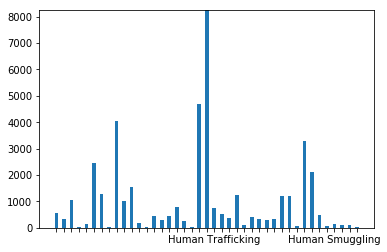

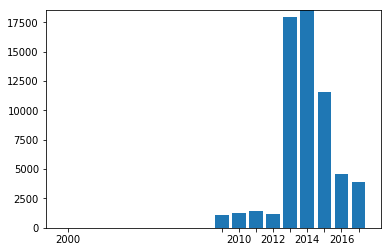

In [4]:
print('1. The earliest date:',pr.date_timestamp.min().date(), '; Last pulled date:',pr.date_timestamp.max().date())
print('----------------------------------------------------------------------------------')
pr['# topics']=pr['topic'].map(lambda x: int(len(x)) if len(x) else None)
print('2. Number of records:',len(pr), '; Percentage of records that have topics:', "{0:.0f}%".format(100*len(pr[~pd.isnull(pr['# topics'])])/len(pr)) )
print('----------------------------------------------------------------------------------')
print('3. Number of records with empty body:',len(pr[pr['body'].map(lambda x: False if len(x) else True)]), '; Number of records with empty title:',len(pr[pr['title'].map(lambda x: False if len(x) else True)]) )
print('----------------------------------------------------------------------------------')
print('Distribution of Number of Topics per a document')
dist_n_topics = pr['# topics'].value_counts(sort=True)
print(dist_n_topics)
print('----------------------------------------------------------------------------------')
print('Topic Distribution')
dist_topics = {}
for row in pr['topic']:
     for topic in row:
        dist_topics[topic['name']] = dist_topics.get(topic['name'], 0) + 1
print(pd.DataFrame.from_records(list(dist_topics.items()), columns=['Topic Name', '# Documents']) ) 
plt.figure(1)
X = np.arange(len(dist_topics))
plt.bar(X, dist_topics.values(), align='center', width=0.5)
_xticks = [list(dist_topics.keys())[i] if i in [21,37] else '' for i in X ]
plt.xticks(X, _xticks)
ymax = max(dist_topics.values()) + 1
plt.ylim(0, ymax)     
print('----------------------------------------------------------------------------------')
print('Empty Topic Distribution by Year')
plt.figure(2)
pr['Year'] = pr['date_timestamp'].map(lambda x: x.year)
empty = pr[pd.isnull(pr['# topics'])]['Year'].value_counts()
plt.bar(empty.index.values, empty.values)
_xticks = ['' if x%2 else int(x) for x in empty.index.values]
plt.xticks(empty.index.values, _xticks)
ymax = max(empty.values) + 1
plt.ylim(0, ymax)

### Subsetting data by only Human Trafficking related articles

In [3]:
def human_trafficking_in_topic(x):
    ht = ''
    for e in x:
        if re.search(r'human\s+traffic',e['name'],re.I):
            ht += ';' + e['name']
    return ht 

# we decided to trust to the original labeling 
# if there is a 'human trafficking' in the body, but the topic does not indicate that
# then we believe the press release is not about human trafficking
def human_trafficking_in_body_title_empty_titles(x):
    ht = ''
    if len(x['topic']):
        if re.search(r'human\s+traffic',str(x['title']),re.I):
            ht += ';' + r'human\s+traffic'
        elif re.search(r'human\s+traffic',str(x['body']),re.I):
            ht += ';' + r'human\s+traffic'
    return ht

pr['ht_in_topic'] = pr['topic'].map(human_trafficking_in_topic)
pr['ht_in_body_title'] = pr.apply(human_trafficking_in_body_title_empty_titles,axis=1)
# a new Human Trafficking dataframe
pr_ht = pr[(pr['ht_in_topic'] != '') | (pr['ht_in_body_title'] != '')]
# statistics
print('human trafficking in topic',len(pr[pr['ht_in_topic']!='']))
print('human trafficking in body or title with empty topic',len(pr[pr['ht_in_body_title']!='']))

human trafficking in topic 757
human trafficking in body or title with empty topic 443


### Cleaning the body and title

80% of time we spend cleaning the data, remaining 20% we spend complaining that data could've been clean better

* Body of press releases have lxml code, let's remove them
<img alt="DOJ Raw Data" src="resources/DOJ_raw_view.png" width="600px" />

* Articles or press releases usually have a location at the beginning of the article

<center>**Press Release Example and Template**</center>
<img alt="example-press-release" src="resources/example_press_release.png" width="400px" />
<center>**New York Times Article**</center>
<img alt="NYT" src="resources/NYT.png" width="600px" />

In [4]:
def remove_location_at_beginning(x):
    if re.search(r'^\s*\w+\s*(\s*\w+\s*){0,1}(,\s*\w+\s*[\.\s]*){0,1}[\-\u2011\u2012\u2013\u2014\u2015]+',x):
        # HYPHEN, NON-BREAKING HYPHEN, FIGURE DASH, EN DASH, EM DASH, HORIZONTAL BAR
        return re.sub(r'^\s*\w+\s*(\s*\w+\s*){0,1}(,\s*\w+\s*[\.\s]*){0,1}[\-\u2011\u2012\u2013\u2014\u2015]+','',x)
    elif re.search(r'^\s*WASHINGTON\s*[,\s]*D\.{0,1}\s*C\.{0,1}\s*[\-\u2011\u2012\u2013\u2014\u2015]+',x,re.I):
        return re.sub(r'^\s*WASHINGTON\s*[,\s]*D\.{0,1}\s*C\.{0,1}\s*[\-\u2011\u2012\u2013\u2014\u2015]+','',x,re.I)    
    else:
        return x
    
# remove lxmls
pr_ht['body'] = pr_ht['body'].map(lambda x: BeautifulSoup(str(x),"lxml").text)
# press releases can have the location of the press release at the beginning of the text
pr_ht['body'] = pr_ht['body'].map(remove_location_at_beginning) 

/Users/ashoydo/virtualenv/web/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/ashoydo/virtualenv/web/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


## Typical architecture for an information extraction system
[Material is taken from here](http://www.nltk.org/book/ch07.html#ref-chunkex-cp)

#### <center>Information Extraction Architecture</center>
<img alt="Architecture" src="resources/information_extraction_architecture.png" width="600px" />

### Segmentation, Tokenization and Tagging Part of Speech
* Let's perform the first three tasks
* If you want, you can improve the standard models based on your corpora, especially the step # 3 POS tagging
* If your corpora consists of 'new' words, the standard libraries could be inaccurate

In [6]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
def ie_preprocess(document):
    sentences = nltk.sent_tokenize(document) 
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences

# create new columns
pr_ht['pos body'] = pr_ht['body'].map(ie_preprocess)
pr_ht['pos title'] = pr_ht['title'].map(ie_preprocess)
pd.options.display.max_colwidth=100
print(pr_ht[['pos body','pos title']].head())    

/Users/ashoydo/virtualenv/web/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/ashoydo/virtualenv/web/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


                                                                                                  pos body  \
2907   [[(Attorney, NNP), (General, NNP), (Eric, NNP), (Holder, NNP), (today, NN), (honored, VBD), (52,...   
4236   [[(A, DT), (federal, JJ), (jury, NN), (in, IN), (Memphis, NNP), (,, ,), (Tenn., NNP), (,, ,), (h...   
5275   [[(Linda, NNP), (Weston, NNP), (,, ,), (her, PRP$), (daughter, NN), (and, CC), (three, CD), (co-...   
7353   [[(The, DT), (Department, NNP), (of, IN), (Justice, NNP), (and, CC), (the, DT), (Corporation, NN...   
13151  [[(Christian, JJ), (Dior, NNP), (Womack, NNP), (,, ,), (a/k/a, VBZ), (“, NNP), (Gucci, NNP), (Pr...   

                                                                                                 pos title  
2907   [[(Attorney, NNP), (General, NNP), (Eric, NNP), (Holder, NNP), (Honors, NNP), (Prosecutors, NNP)...  
4236   [[(Memphis, NNP), (Man, NNP), (Found, NNP), (Guilty, NNP), (of, IN), (Child, NNP), (Sex, NNP), (...  
5275   [[(Fe

#### List of all possible Part of Speech tags in NLTK

In [8]:
#nltk.download('tagsets')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Pre-entity detection stage: Noun Phrase chunking or NP-chunking
We will search for chunks corresponding to individual noun phrases
<img alt="Chunk Segmentation" src="resources/chunk-segmentation.png" width="600px" />
<center>**Tree representation**</center>
<img alt="Chunk Segmentation" src="resources/chunk-tree.png" width="600px" />

### Rule-based approach: NP-chunking with regular expressions
* Let's define the rule (**chunk grammar**) that will divide the sentences into our NP-chunks based on POS tagging
* Part-of-speech tags are delimited using angle brackets
* This rule will chunk any sequence of tokens beginning with an optional determiner or possessive pronoun, followed by zero or more adjectives of any type (including relative adjectives like earlier/JJR), followed by one or more nouns of any type

In [32]:
# define the chunk grammar
# in general case you want the chunk grammar as below
#grammar = """NP: {<DT|PRP\$>?<JJ.*>*<NN.*>+}"""
# for our case, let's have this one instead
grammar = """NP: {<JJ.*>*<NN.*>+}"""

# Using the grammar, create a chunk parser
cp = nltk.RegexpParser(grammar)

# Chunk the sentences based on your rule
pr_ht['chunks'] = pr_ht['pos body'].map(lambda sentences: [cp.parse(sentence) for sentence in sentences])

# Print one example
pd.options.display.max_colwidth=1000
print(pr_ht['body'].iloc[2])
print(pr_ht['chunks'].iloc[2])

Linda Weston, her daughter and three co-defendants are charged in a 193-count indictment, unsealed today, with racketeering, murder in aid of racketeering, hate crimes, sex trafficking, forced labor, theft, fraud and other crimes. The indictment alleges that Weston and her associates carried out a racketeering enterprise that targeted victims with mental disabilities as part of a scheme to steal disability payments from the victims and the Social Security system. As part of the scheme, Weston persuaded each victim to make her the designated recipient of their Social Security disability payments in exchange for the promise of a comfortable place to live. Once appointed as the designated recipient of disability payments, Weston, aided by the co-defendants, subjected the victims to subhuman conditions of captivity.
According to the indictment, the defendants beat the victims, kept them captive in locked closets, basements and attics, deprived them of adequate food and medical care, and mo

/Users/ashoydo/virtualenv/web/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


#### Here you can play around with chunk grammar to accurately determine NP-chunks

In [29]:
# define the index of the document you want to investigate
i = 0

# extract the document's raw text
document = pr_ht['body'].iloc[i]
print('Original document')
print(document)
print('------------------------------------------------')

# process your document
processed_document = nltk.sent_tokenize(document) 
processed_document = [nltk.word_tokenize(sent) for sent in processed_document]
processed_document = [nltk.pos_tag(sent) for sent in processed_document]
print('\nProcessed document')
print(processed_document)
print('------------------------------------------------')

# define the chunk rule, let's say everything will be NP if a noun preceded by ) or more adjectives  
grammar = """My Chunk. Yeah!: {<JJ*>*<NN*>+}"""

# create a chunk parser
cp = nltk.RegexpParser(grammar)

# chunk your document 
chunk_trees = [cp.parse(sent) for sent in processed_document]
print('\nYour Chunked Phrases')
for tree in chunk_trees:
    for subtree in tree.subtrees():
        if subtree.label() == 'My Chunk. Yeah!': 
            print(subtree)
print('------------------------------------------------')
print('Visual representation (tree) of the document\'s first sentence')
#chunk_trees[0].draw()

Original document
 Attorney General Eric Holder today honored 52 prosecutors, law enforcement partners and victim advocates in 13 communities for their     leadership protecting children from sexual abuse and exploitation. The awards were presented at the 2011 National Strategy Conference on Combating Child Exploitation in San Jose, Calif.       Attorney General Eric Holder has made one of the department’s four key priorities the protection of those most vulnerable – children, the elderly, and victims of hate crimes, human trafficking and exploitation.          “Through their work in urban, rural and tribal communities – and through cutting-edge online efforts – these individuals are advancing bold, innovative and collaborative solutions to keep our children safe from all forms of exploitation and abuse,” said Attorney General Holder. “By focusing on prevention and intervention, as well as proven enforcement and prosecution strategies, these award recipients are strengthening our abili

### Machine Learning approach: NP-chunking (I'll leave this as an exercise for you)
* For ML approach, you need annotated data. Unfortunately DOJ isn't.
* You can use existing annotated data like WSJ data in the NLTK package. Then you can assume that DOJ and this annotated data are from the same distribution and the models you built on the annotated data will work fine for DOJ data
* Simple ML model can be built by using n-gram tagger to label sentences with chunk tags [part 3.2](http://www.nltk.org/book/ch07.html#ref-chunkex-cp)
* More comprehensive ML model would be a classifier-based chunkers such as the ConsecutiveNPChunker [part 3.3](http://www.nltk.org/book/ch07.html#ref-chunkex-cp)

## Find the category of Human Trafficking
<img alt="Example HT" src="resources/HT_example1.png" width="600px" />

* Usually titles are very informative stating the gender, location of a trafficker and the category of Human Trafficking
* The first paragraph is usually more relevant to an incident than the next ones. The last paragraph usually has general information on Human Trafficking rather than information related to the incident (**task: divide a document onto paragraphs**)

### Entity Detection - Category

In [69]:
def human_trafficking_category(chunk_trees):
    categories = []
    for tree in chunk_trees:
        for subtree in tree.subtrees():
            # find all NP-chunk
            if subtree.label() == 'NP':
                leaves = [w[0] for w in subtree.leaves()]
                # if an NP-chunk has trafficking in it, then we start extracting category
                if 'trafficking' in leaves:
                    # clean up and creating a string out of a list
                    c = ' '.join([re.sub('[^a-z]','',x.lower()) for x in leaves if not re.search('human',x,re.I)])
                    if re.sub(r'\s','',c) != '':
                        categories.append(re.sub('(^\s+|\s+$)','',c))
                        
    categories2 = Counter(categories)
    keys = []
    for key in categories2.keys():
        if len(keys) == 0:
            keys.append(key)
        else:
            for i,k in enumerate(keys):
                if key in k:
                    break
                elif k in key:
                    keys[i] = key
                    break
            if len(keys) == i+1:
                keys.append(key)
                
    new_categories = dict((k, 0) for k in keys)  
    for key in categories2:
        for key1 in new_categories:
            if key in key1:
                new_categories[key1] += categories2[key]
                break
    
    new_categories = sorted(new_categories, key=new_categories.get) 
    if len(new_categories):
        category = new_categories[-1]
        if category == 'trafficking':
            category = ''
    else:
        category = ''
    return(category)            
 
#print(human_trafficking_category(pr_ht['chunks'].iloc[10]))    
pr_ht['category'] = pr_ht['chunks'].map(human_trafficking_category)  
print(pr_ht['category'].head(50))
print('# of articles that have a category:',len(pr_ht[pr_ht['category']!='']),\
      round(100*len(pr_ht[pr_ht['category']!=''])/len(pr_ht),2))

2907                domestic sex trafficking
4236                   child sex trafficking
5275                         sex trafficking
7353                                        
13151                sex trafficking females
13188                                       
13196                 trafficking task force
13228                        sex trafficking
13268                                       
13273                                       
13292                                       
13302                                       
13311                                       
16421                        sex trafficking
16448        federal sex trafficking charges
16465                        sex trafficking
16516    modernday slavery   sex trafficking
20481          child pornography trafficking
20489                                       
20509                                       
20532                                       
20585                                       
20807     

/Users/ashoydo/virtualenv/web/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Extract Human Trafficking Category Through Spacy
Let's use dependency parsing method in Spacy to detect categories of Human Trafficking
This is a big model and very resource consuming

In [6]:
import spacy

# load spacy's large model (be careful it has size of 812 MB!)
nlp = spacy.load('en_core_web_lg')

def type_ht_spacy (document, token, ptag):    
    types = []
    for chunk in document.noun_chunks:
        if re.search(token,chunk.root.text, re.I):
            doc = nlp(chunk.text)
            for word in doc:
                if word.pos_ == ptag and not re.search(token,word.text,re.I) and not re.search('human',word.lemma_):
                    types.append(word.lemma_)               
    return Counter(types)

pr_ht['type ht spacy'] = pr_ht['body'].map(lambda x: type_ht_spacy(nlp(x),'traffic','NOUN'))   
print(pr_ht['type ht spacy'])
print('# of articles with a category:',len(pr_ht[pr_ht['type ht spacy'] != {}]))

2907                                        {'sex': 3}
4236                            {'child': 4, 'sex': 6}
5275                                        {'sex': 1}
7353                                                {}
13151                                       {'sex': 2}
13188                                               {}
13196                                               {}
13228              {'combat': 1, 'sex': 1, 'labor': 1}
13268                                               {}
13273                                               {}
13292                                               {}
13302                                               {}
13311                                    {'combat': 1}
16421                                       {'sex': 1}
16448                                       {'sex': 7}
16465                                       {'sex': 2}
16516                                       {'sex': 4}
20481    {'internet': 1, 'child': 1, 'pornography': 1}
20489     

/Users/ashoydo/virtualenv/web/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [8]:
print('# of articles with a category:',len(pr_ht[pr_ht['type ht spacy'] != {}]))

# of articles with a category: 589
